In [86]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [1]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [88]:
NUM_CLASSES = 9

# Dataset reading

In [89]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [90]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [92]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [93]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_10 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)                860       
_________________________________________________________________
dropout_11 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_17 (Dense)             (None, 9)                 99        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [94]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [95]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [96]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
10/10 [==============================] - 0s 9ms/step - loss: 2.2730 - accuracy: 0.1975 - val_loss: 2.1388 - val_accuracy: 0.3085

Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 2/1000
10/10 [==============================] - 0s 3ms/step - loss: 2.1684 - accuracy: 0.2241 - val_loss: 2.0865 - val_accuracy: 0.3085

Epoch 00002: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 3/1000
10/10 [==============================] - 0s 3ms/step - loss: 2.1397 - accuracy: 0.2183 - val_loss: 2.0494 - val_accuracy: 0.3209

Epoch 00003: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 4/1000
10/10 [==============================] - 0s 2ms/step - loss: 2.0884 - accuracy: 0.2515 - val_loss: 2.0113 - val_accuracy: 0.3532

Epoch 00004: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 5/1000
10/10 [==============================] - 0s 2ms/step - loss: 2.0474 - accuracy: 0.2614 - val_lo

In [97]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

4/4 [==============================] - 0s 0s/step - loss: 0.4851 - accuracy: 0.8433


In [98]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [99]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[4.67176797e-05 3.45956087e-01 2.64030039e-01 1.08096934e-07
 1.84929565e-08 2.30665709e-09 8.08687299e-04 3.89155149e-01
 3.19236642e-06]
7


# Confusion matrix

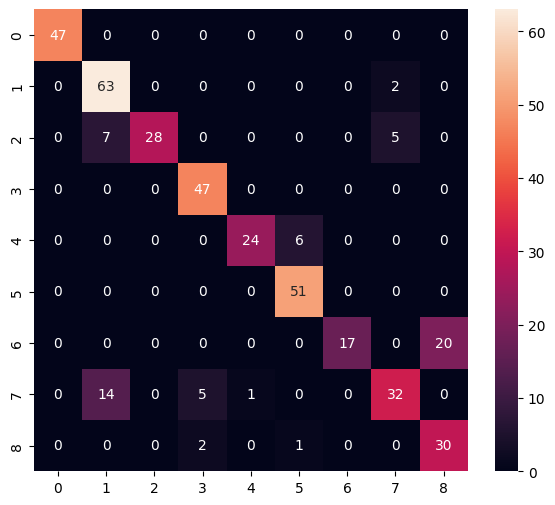

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       0.75      0.97      0.85        65
           2       1.00      0.70      0.82        40
           3       0.87      1.00      0.93        47
           4       0.96      0.80      0.87        30
           5       0.88      1.00      0.94        51
           6       1.00      0.46      0.63        37
           7       0.82      0.62      0.70        52
           8       0.60      0.91      0.72        33

    accuracy                           0.84       402
   macro avg       0.88      0.83      0.83       402
weighted avg       0.87      0.84      0.84       402



In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [101]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [102]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\rosha\AppData\Local\Temp\tmpo0fw2mnm\assets


INFO:tensorflow:Assets written to: C:\Users\rosha\AppData\Local\Temp\tmpo0fw2mnm\assets


6640

# Inference test

In [103]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [104]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [105]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [106]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [107]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.6717676e-05 3.4595624e-01 2.6403004e-01 1.0809672e-07 1.8492919e-08
 2.3066569e-09 8.0868689e-04 3.8915512e-01 3.1923635e-06]
7
